## iPyLeaflet
[ipyleaflet](https://github.com/ellisonbg/ipyleaflet) is a bridge between jupyter notebooks and the [leaflet](http://leafletjs.com/)  javascript library for drawing maps.

ipyleaflet comes with a few examples notebooks (this notebook was derived from one) but very little documentation,
for more documentation read the [Leaflet IPA](http://leafletjs.com/reference.html)

For installation directions, see the README on [ipyleaflet](https://github.com/ellisonbg/ipyleaflet)

In [1]:
from ipyleaflet import (
    Map,
    Marker,
    TileLayer, ImageOverlay,
    Polyline, Polygon, Rectangle, Circle, CircleMarker,
    GeoJSON,
    DrawControl
)

## Visualizing the distribution of the observations

## Load the required libraries

In [2]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math

In [3]:
import findspark
findspark.init()

from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/computeStats.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

In [4]:
import sys
sys.path.append('./lib')

import numpy as np
from numpy_pack import packArray,unpackArray
from computeStats import computeOverAllDist, STAT_Descriptions

In [5]:
### Read the data frame from pickle file

data_dir='../../Data/Weather'
file_index='SSSSBBBB'
meas='TOBS'

from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
print('keys from STAT=',STAT.keys())

#!ls -ld $data_dir/*.parquet

#read data
filename=data_dir+'/decon_%s_%s.parquet'%(file_index,meas)

df=sqlContext.read.parquet(filename)
print(df.count())
df.show(2)

('keys from STAT=', ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP'])
1642
+------------------+------------------+-------------------+---------+--------+--------+---------+-----------+-------------------+------------------+-------------------+------------------+-----------+---------+------+--------------------+------+
|           coeff_1|           coeff_2|            coeff_3|elevation|   label|latitude|longitude|measurement|              res_1|             res_2|              res_3|          res_mean|    station|total_var|undefs|              vector|  year|
+------------------+------------------+-------------------+---------+--------+--------+---------+-----------+-------------------+------------------+-------------------+------------------+-----------+---------+------+--------------------+------+
|1772.7287399167628|-949.0552666287747| -580.0576015792132|   2208.0|SSSSBBBB| 35.6833|-105.9333|       TOBS| 0.3651529547809588|0.2294696003906319| 0.1513749759701979|0.8221289315611902|USC

In [22]:
#extract longitude and latitude for each station
feature='coeff_3'
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT station, latitude,longitude,elevation,%s FROM weather"%feature
print(Query)
df1 = sqlContext.sql(Query)
df1.show(4)

SELECT station, latitude,longitude,elevation,coeff_3 FROM weather
+-----------+--------+---------+---------+-------------------+
|    station|latitude|longitude|elevation|            coeff_3|
+-----------+--------+---------+---------+-------------------+
|USC00298090| 35.6833|-105.9333|   2208.0| -580.0576015792132|
|USC00299496| 35.2667|-105.3572|   1757.2|-381.51484556583256|
|USC00299496| 35.2667|-105.3572|   1757.2|-467.71592211909103|
|USC00299496| 35.2667|-105.3572|   1757.2|-509.90945031663875|
+-----------+--------+---------+---------+-------------------+
only showing top 4 rows



In [23]:
df2=df1.groupby(['station','latitude','longitude','elevation']).agg({"station":"count",feature:"mean"})
pdf=df2.toPandas()
pdf.sort_values(by=["station"],inplace=True)
pdf.head(3)

,station,latitude,longitude,elevation,count(station),avg(coeff_3)
52,USC00290222,35.1000,-106.6167,1565.1,9,-550.894036
40,USC00290225,35.1344,-106.4878,1865.4,21,-412.780779
67,USC00290743,35.7833,-106.2667,1848.0,34,-502.305457


In [24]:
#define a mapping from the range of the value to hex colors.
from matplotlib.colors import rgb2hex
_avg='avg(%s)'%feature
_min=pdf[_avg].min()
_max=pdf[_avg].max()
_min,_max

import pylab as plt
cmap=plt.get_cmap('jet')
def get_color(val):
    x=(val-_min)/(_max-_min)
    return(rgb2hex(cmap(x)[:3]))

get_color(-10000.)

u'#000080'

## Map

In [25]:
min_lat,max_lat,min_long,max_long = box = (pdf['latitude'].min()-.1, pdf['latitude'].max()+.1, pdf['longitude'].min()-.1, pdf['longitude'].max()+.1)


In [26]:
center = [(min_lat+max_lat)/2, (min_long+max_long)/2]
zoom = 9

m = Map(default_tiles=TileLayer(opacity=1.0), center=center, zoom=zoom)

r = Rectangle(bounds=[[min_lat,min_long],[max_lat,max_long]], weight=5, fill_opacity=0.0)
m += r

lat_margin=(max_lat-min_lat)/4
long_margin=(max_long-min_long)/4
circles = []
for index,row in pdf.iterrows():
    _lat=row['latitude']
    _long=row['longitude']
    _count=row['count(station)']
    _coef=row[_avg]
    # taking sqrt of count so that the  area of the circle corresponds to the count
    c = Circle(location=(_lat,_long), radius=int(300*15), weight=1,
            color="#FFF", opacity=0.2, fill_opacity=0.8,
            fill_color=get_color(_coef))
    circles.append(c)
    m.add_layer(c)
m    

### excercises:
* Add a legend that relates the colors to values.
* Leaflet supports a variety of maps. See if you can get a topographical map as the background.

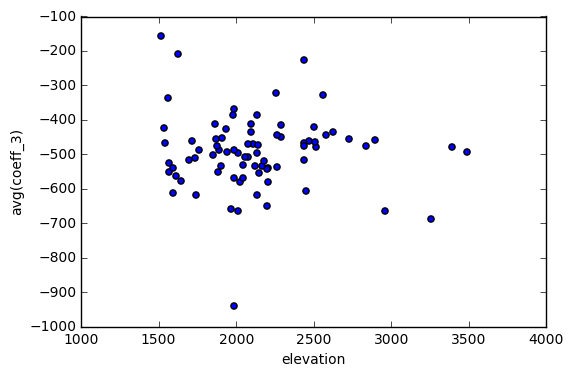

In [28]:
%matplotlib inline
pdf.plot.scatter(x='elevation',y='avg(coeff_3)');

In [15]:
RDD1=sc.parallelize(["spark  basics", "spark big  data analysis", "spring"]) 
RDD2=sc.parallelize(["spark using pyspark", "big data"])
 
RDD1.subtract(RDD2).collect()

['spring', 'spark big  data analysis', 'spark  basics']